In [1]:
# 필요한 라이브러리 불러오기
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

In [2]:
# 모델 및 데이터 경로 설정
model1_path = "방법 3/model/model1_E_vs_NotE.cbm"
model2_path = "방법 3/model/model2_3class.cbm"
model3_path = "방법 3/model/model3_A_vs_B.cbm"
data_path = "피처_43/피처 선택/43_Segment 추가.csv"

In [3]:
# 모델 불러오기
model1 = CatBoostClassifier(); model1.load_model(model1_path)
model2 = CatBoostClassifier(); model2.load_model(model2_path)
model3 = CatBoostClassifier(); model3.load_model(model3_path)

In [4]:
# 데이터 불러오기 및 feature 컬럼 정의
df_full = pd.read_csv(data_path)
feature_cols = df_full.columns.drop(['ID', 'Segment'])

In [33]:
df_full['Segment'].value_counts()

Segment
E    1922052
D     349242
C     127590
A        972
B        144
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 13
plt.rcParams['axes.unicode_minus'] = False

In [6]:
# ▶ 1. 데이터 분리
X = df_full[feature_cols]
y = df_full['Segment']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
# ▶ 2. Stage 1: model1 (E vs NotE)
pred1 = model1.predict(X_valid)
df_stage1 = X_valid.copy()
df_stage1['pred1'] = pred1.flatten()
df_stage1['Segment_pred'] = np.where(df_stage1['pred1'] == 1, 'E', 'NotE')

In [8]:
# ▶ 3. Stage 2: model2 (C / D / NotCD)
df_not_e = df_stage1[df_stage1['Segment_pred'] != 'E'].copy()
pred2 = model2.predict(df_not_e[feature_cols])
df_not_e['pred2'] = pred2.flatten()
df_not_e['Segment_pred'] = df_not_e['pred2']  # 'C', 'D', 'NotCD'

In [26]:
# ▶ 4. Stage 3: model3 (A vs B)
df_not_cd = df_not_e[df_not_e['Segment_pred'] == 'NOT_CD'].copy()
pred3 = model3.predict(df_not_cd[feature_cols])
df_not_cd['pred3'] = pred3.flatten()
df_not_cd['Segment_pred'] = df_not_cd['pred3']  # 'A', 'B'

In [27]:
# ▶ 5. 최종 통합 결과 결합
df_final = pd.concat([
    df_stage1[df_stage1['Segment_pred'] == 'E'],
    df_not_e[df_not_e['Segment_pred'].isin(['C', 'D'])],
    df_not_cd  # 이미 'A', 'B'로 변경됨
])

In [28]:
# ▶ 6. 실제 라벨과 예측 결과 정리
df_final = df_final.merge(df_full[['ID', 'Segment']], left_index=True, right_index=True)
y_true = df_final['Segment']
y_pred = df_final['Segment_pred']

In [29]:
# ▶ 7. 혼동 행렬 시각화
labels = ['A', 'B', 'C', 'D', 'E']
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

<Figure size 800x600 with 0 Axes>

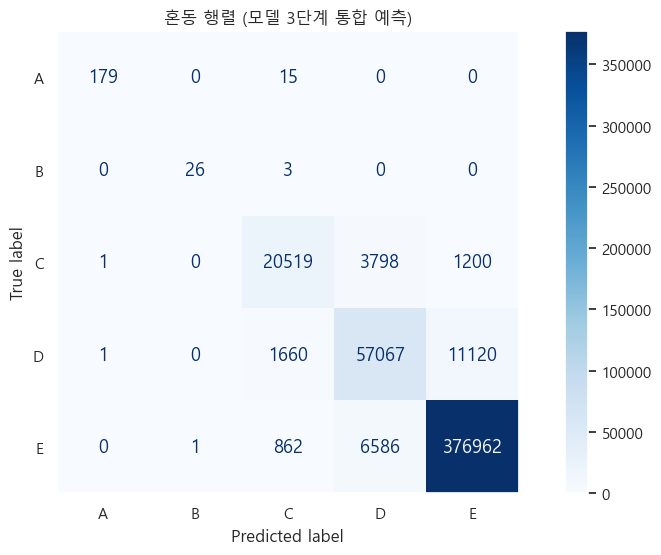

In [30]:
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("혼동 행렬 (모델 3단계 통합 예측)")
plt.grid(False)
plt.show()

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix

# ▶ 클래스 순서
labels = ['A', 'B', 'C', 'D', 'E']

# ▶ 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred, labels=labels)

# ▶ 정확 예측률 계산
print("📊 클래스별 정확 예측률 (%):")
for idx, label in enumerate(labels):
    correct = cm[idx, idx]
    total = cm[idx].sum()
    accuracy = correct / total * 100 if total > 0 else 0
    print(f"- {label}를 {label}로 맞춘 비율: {accuracy:.2f}% ({correct}/{total})")


📊 클래스별 정확 예측률 (%):
- A를 A로 맞춘 비율: 92.27% (179/194)
- B를 B로 맞춘 비율: 89.66% (26/29)
- C를 C로 맞춘 비율: 80.41% (20519/25518)
- D를 D로 맞춘 비율: 81.70% (57067/69848)
- E를 E로 맞춘 비율: 98.06% (376962/384411)


In [32]:
from sklearn.metrics import f1_score

f1_micro = f1_score(y_true, y_pred, average='micro')
print(f"\n📌 F1 Micro Score: {f1_micro:.4f}")


📌 F1 Micro Score: 0.9474


In [34]:
print(df_not_cd['Segment_pred'].value_counts())

Segment_pred
A    181
B     27
Name: count, dtype: int64


In [35]:
print("y_true 총 개수:", len(y_true))
print("y_pred 총 개수:", len(y_pred))
print("혼동 행렬 전체 합:", cm.sum())
print("df_final shape:", df_final.shape)
print("Segment 분포:\n", y_true.value_counts())


y_true 총 개수: 480000
y_pred 총 개수: 480000
혼동 행렬 전체 합: 480000
df_final shape: (480000, 49)
Segment 분포:
 Segment
E    384411
D     69848
C     25518
A       194
B        29
Name: count, dtype: int64
